In [1]:
from fast_cleaning import fast_cleaning_longer, fast_cleaning_merge
from validation import get_efficiency, get_fake_rate, get_purity
from cleaning_old_longer import cleaning_old_longer
from cleaning_old_merge import cleaning_old_merge
from coverage_cleaning import coverage_cleaning
from validation import get_duplication_rate
from matplotlib import pyplot as plt
from copy import deepcopy
from get_data import *
from time import time
import pandas as pd
import matplotlib
import os


# Create variables for analyse

In [2]:
path = "data"
event_list = os.listdir(path)
cleaning_type_list = ["raw",
                      "cleaning_old_longer",
                      "cleaning_old_merge",
                      "fast_cleaning_longer",
                      "fast_cleaning_merge",
                      "coating_cleaning"]

cleaning_func_list = [list,
                      cleaning_old_longer,
                      cleaning_old_merge,
                      fast_cleaning_longer,
                      fast_cleaning_merge,
                      coverage_cleaning]
plot_title = ["Efficiency",
              "Number of tracks left",
              "Fake rate",
              "Duplicates",
              "Purity"]

# Create data objects for store information

In [3]:
event_list = [event_list[i:i + 3] for i in range(0, len(event_list), 3)]
df_efficiency = pd.DataFrame(columns=cleaning_type_list)
df_time = pd.DataFrame(columns=cleaning_type_list)
df_fake_rate = pd.DataFrame(columns=cleaning_type_list)
df_tracks_number = pd.DataFrame(columns=cleaning_type_list)
df_duplicate = pd.DataFrame(columns=cleaning_type_list)
df_purity = pd.DataFrame(columns=cleaning_type_list)

# Collect statistics of all types of cleaning

In [4]:
for event_number, event in enumerate(event_list):
    track_file = event[0]
    hit_file = event[1]
    id_file = event[2]

    tracks = get_tracks_data(f'{path}/{track_file}', f'{path}/{hit_file}')
    hits = get_hits_data_for_validation(f'{path}/{hit_file}')
    track_id_list = get_track_id(f'{path}/{id_file}')

    print(f"###############################{event_number}/{len(event_list)}###############################")
    if not len(tracks) or not len(hits):
        print("ZERO")
        continue

    for cleaning_type, cleaning_func in zip(cleaning_type_list, cleaning_func_list):
        s = time()
        cleaned_tracks = cleaning_func(deepcopy(tracks))
        df_time.at[event_number, cleaning_type] = time() - s
        df_tracks_number.at[event_number, cleaning_type] = len(cleaned_tracks)
        df_efficiency.at[event_number, cleaning_type] = get_efficiency(cleaned_tracks, hits, min_length=9)
        df_fake_rate.at[event_number, cleaning_type] = get_fake_rate(cleaned_tracks, hits, min_length=9)
        df_duplicate.at[event_number, cleaning_type] = get_duplication_rate(cleaned_tracks, hits, min_length=9)
        df_purity.at[event_number, cleaning_type] = get_purity(cleaned_tracks, hits, min_length=9)

###############################0/1000###############################
Number of reco tracks: 180
Number of real selected tracks: 266
Number of fake tracks: 1
Number of real selected tracks: 5038
Number of real reco tracks: 4857
Number of reco tracks: 8987
Number of real reco tracks: 180
Number of reco tracks: 8987
Before cleaning there are 8987 tracks
Starting the first stage of merging duplicates
The first stage of merging completed in 3.4509642124176025 seconds
Starting the second stage of merging duplicates
The second stage of merging completed in 18.114956378936768 seconds
Starting separate tracks
Track separating completed in 1.3379688262939453 seconds
Staring sorting the points in the track
Sorting completed in 1.5290305614471436 seconds
After cleaning there are 1612 tracks
Number of reco tracks: 169
Number of real selected tracks: 266
Number of fake tracks: 0
Number of real selected tracks: 183
Number of real reco tracks: 13
Number of reco tracks: 1612
Number of real reco tracks:

ZeroDivisionError: division by zero

# Drawing

In [10]:
df_list = [df_efficiency, df_tracks_number, df_fake_rate, df_duplicate, df_purity, df_time]
df_names = ["Efficiency",
            "Number of tracks left",
            "Fake rate",
            "Duplicates",
            "Purity",
            "Time"]
for df, name in zip(df_list, df_names):
    df.to_csv(f"{name}.csv", index=False)

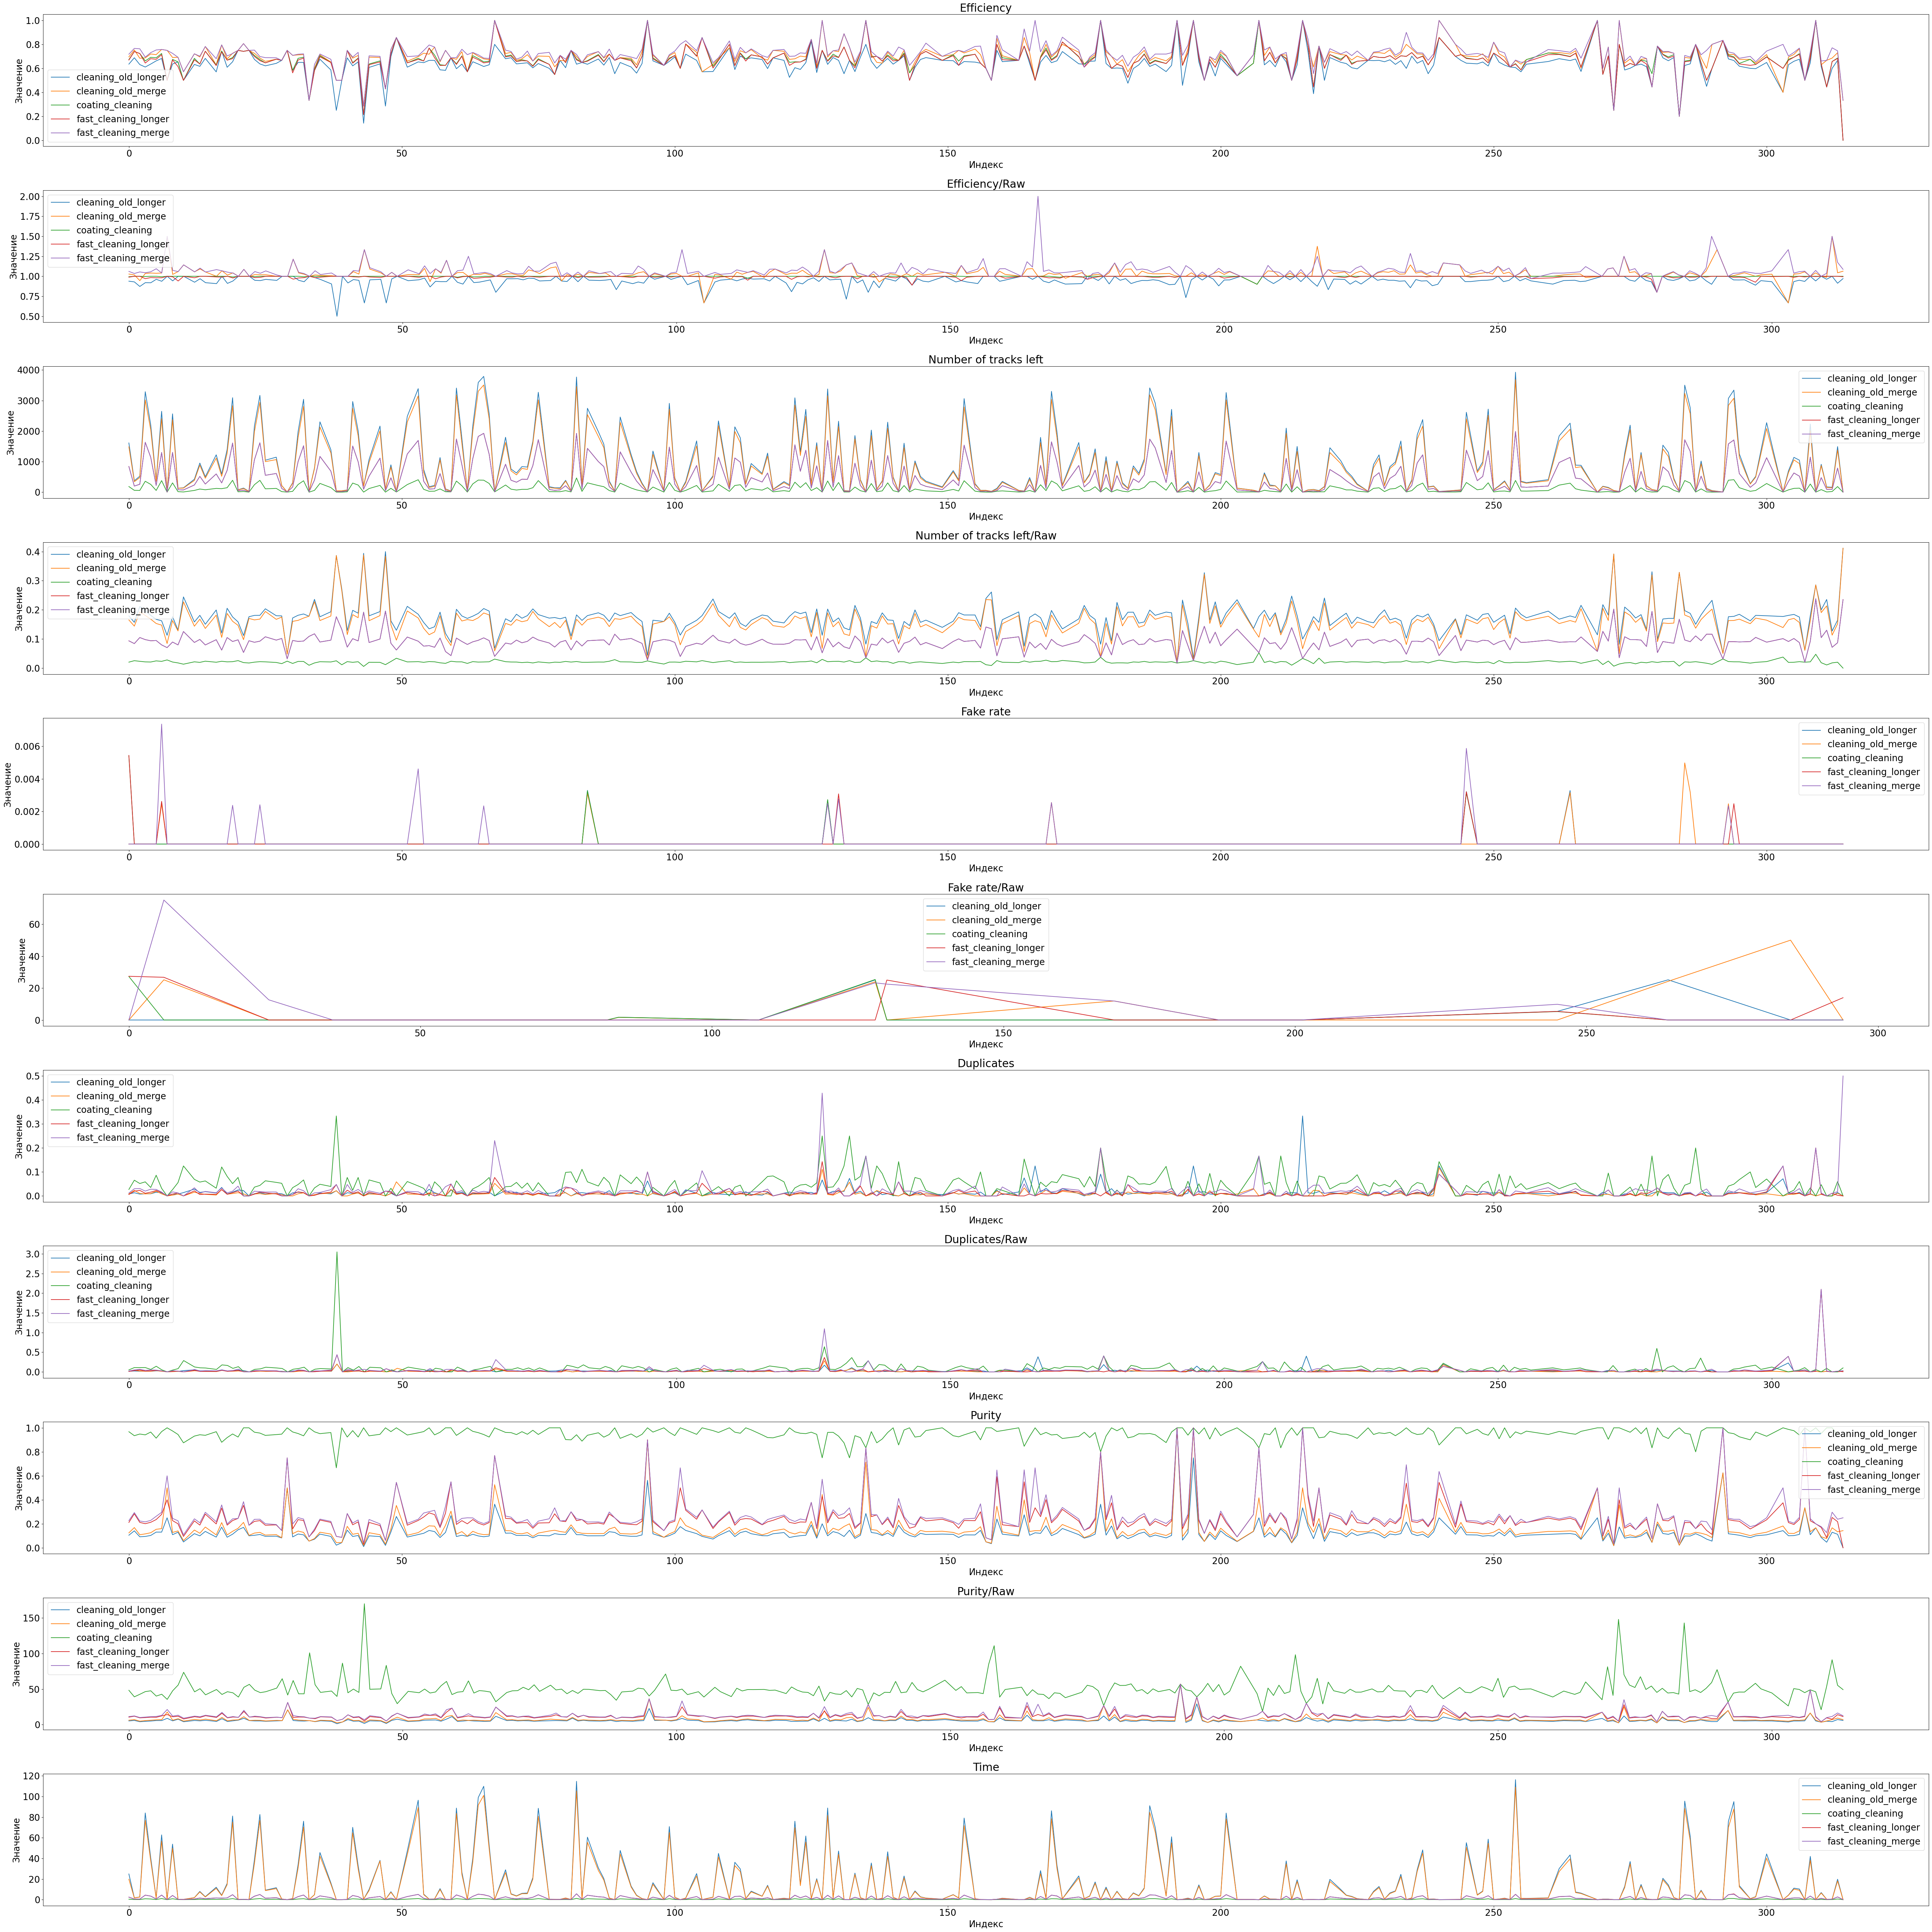

In [5]:
matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(11, 1, figsize=(60, 60))

df_list = [df_efficiency, df_tracks_number, df_fake_rate, df_duplicate, df_purity]
for plot_id, df_id in zip(range(0, (len(df_list) + 1) * 2, 2), range(len(df_list))):
    df_normalized = df_list[df_id][df_list[df_id]["raw"] != 0]
    df_normalized = df_normalized.div(df_normalized["raw"], axis=0)

    for j, df in enumerate([df_list[df_id], df_normalized]):
        for column in df.columns.difference(["raw"]):
            axs[plot_id + j].plot(df.index, df[column], label=column)
        axs[plot_id + j].set_xlabel("Индекс")
        axs[plot_id + j].set_ylabel("Значение")
        axs[plot_id + j].set_title(plot_title[df_id] + "/Raw" if j else plot_title[df_id])
        axs[plot_id + j].legend()

for column in df_time.columns.difference(["raw"]):
    axs[len(df_list) * 2].plot(df_time.index, df_time[column], label=column)
axs[len(df_list) * 2].set_xlabel("Индекс")
axs[len(df_list) * 2].set_ylabel("Значение")
axs[len(df_list) * 2].set_title('Time')
axs[len(df_list) * 2].legend()

plt.tight_layout()
plt.show()